### 1. Introduction

The goal of this analysis is to explore the engagement dynamics of Facebook statuses in Thailand, focusing particularly on the impact of video content versus other forms of social media content.The dataset includes 2,297 entries, detailing various post types (e.g., video, photo) along with engagement metrics such as likes, loves, comments, shares, and reactions (wows, hahas, sads, angrys). The underlying hypothesis is that video content generates higher engagement levels than other types of content, making it an advantageous tool for the firm to enhance visibility and interaction on its social media marketing campaigns. The analysis will employ principal component analysis (PCA) for dimensionality reduction, K-Means clustering for segmentation, and logistic regression to predict the likelihood of a post being a video based on engagement metrics. Understanding engagement patterns is critical for our firm to optimize its content strategy, thereby maximizing reach and interaction for our clients. By doing so, we will ensure the best return on investment and measurable impact.

### 2. Videos vs. Other Content in Terms of Engagement

I will first calculate the average number of reactions (likes, loves, etc.) for video content and compare it with other forms of content. This will allow us to determine how videos perform in terms of total engagement and specific types of reactions. I will then look at metrics such as likes, loves, comments, shares, wows, hahas, sads, and angrys, to get a comprehensive understanding of engagement patterns across different content types.

In [1]:
import pandas as pd

#Load the dataset
data_path = 'facebook_live_data.xlsx'
data = pd.read_excel(io=data_path)

#Display the first few rows of the dataframe to understand its structure
data.head(n=3)

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,video,2018-04-22 06:00:00,512,262,432,92,3,1,1,0
1,2,photo,2018-04-18 03:22:00,0,0,204,9,0,0,0,0
2,3,video,2018-04-18 00:24:00,614,72,418,70,10,2,0,3


The dataset consists of 2,297 entries and 11 columns, including:

- `status_id`: A unique identifier for each status/post.
- `status_type`: The type of post (e.g., video, photo).
- `time_published`: The date and time when the post was published.
- `num_comments`: The number of comments the post received.
- `num_shares`: The number of times the post was shared.
- `num_likes`: The number of likes the post received.
- `num_loves`: The number of love reactions the post received.
- `num_wows`: The number of wow reactions the post received.
- `num_hahas`: The number of haha reactions the post received.
- `num_sads`: The number of sad reactions the post received.
- `num_angrys`: The number of angry reactions the post received.

Each row represents a social media post with various metrics on engagement and reactions.

In [2]:
# Group the data by status type and calculate the average of each reaction metric
avg_reactions_by_type = data.groupby('status_type').mean()

# Calculate total engagement (sum of all reactions and comments) for each post type
total_engagement_metrics = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
avg_reactions_by_type['total_engagement'] = avg_reactions_by_type[total_engagement_metrics].sum(axis=1)

avg_reactions_by_type.round(decimals=2)

,status_id,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,total_engagement
status_type,,,,,,,,,,,
photo,1074.19,2016-07-31 02:57:27.855595520,13.07,2.27,194.11,1.43,0.69,0.17,0.14,0.02,211.90
text,1115.37,2017-02-18 03:57:39.402984960,38.12,2.47,442.37,1.97,1.40,0.10,0.25,0.04,486.72
video,1287.97,2017-06-19 17:18:21.748071936,575.89,111.02,232.99,35.63,2.94,1.52,0.44,0.25,960.67


Based on the analysis of the average reactions to different types of content on Facebook:

- **Videos** significantly outperform other content types in terms of total engagement, with an average total engagement score of 960.67. This encompasses all forms of engagement: likes, loves, comments, shares, and reactions such as wows, hahas, sads, and angrys. Videos also lead for individual engagements of all types except likes, which will be discussed later.
- **Text posts** follow with an average total engagement of 486.72, suggesting that while they can generate significant interaction, they fall substantially behind videos. Text posts, interestingly enough, receive the more likes on average as compared to photo or video posts.
- **Photos** receive the least total engagement, with an average of 211.90. This indicates that while photos can attract attention, they do not engage users as deeply as videos or even text posts.

In terms of specific reactions:
- **Videos** lead dramatically in comments (575.89 on average) and shares (111.02), which are key indicators of deep engagement. Users who leave comments are invested in the content, and users who share it with others either want to spread the message in the video or wish to discuss it with another person. In all these cases, the user has formed some level of attachment to the video and will most likely result in it having greater reach and impressions.
- For **likes**, videos have an average of 232.99, which is lower than text posts (442.37) but higher than photos (194.11). This is a counter-intuitive finding - one would expect that likes would behave similarly to all other forms of engagement. From the data currently available, part of the deficit in likes against text posts could be explained by the fact that videos have more love reactions on average, which would reduce their likes count. This does not explain the entire deficit though, and further research would be required before definitive claims could be made.
- Videos also dominate in reactions that indicate emotional engagement (loves, wows, hahas, sads, angrys), with significantly higher averages than photos and text posts, highlighting their ability to evoke a broader range of emotions from the audience. This only reinforces the statement made earlier: videos are significantly more effective at gathering emotional investment than text or photo content.

From this analysis, it is clear that videos lead in terms of total engagement and in engagement on nearly all specific reactions, especially those that imply a higher level of viewer involvement, such as comments and shares. This underscores the effectiveness of videos in fostering a more engaged and interactive audience, aligning with the hypothesis that videos are a potent tool for maximizing social media engagement.

### 3. Pricipal Component Analysis (PCA)

For the Principal Component Analysis (PCA), I will focus on the engagement metrics as they provide quantitative measures of user interaction with the content. These metrics include `num_comments`, `num_shares`, `num_likes`, `num_loves`, `num_wows`, `num_hahas`, `num_sads`, and `num_angrys`. I exclude `status_id` since it is just an identifier, and `time_published` as it is a timestamp that does not directly contribute to engagement in the context of PCA.

- First, I will standardize these metrics to ensure that each metric contributes equally to the analysis, regardless of their original scales.
- Then, I will perform PCA to identify the principal components that explain the most variance in the dataset.

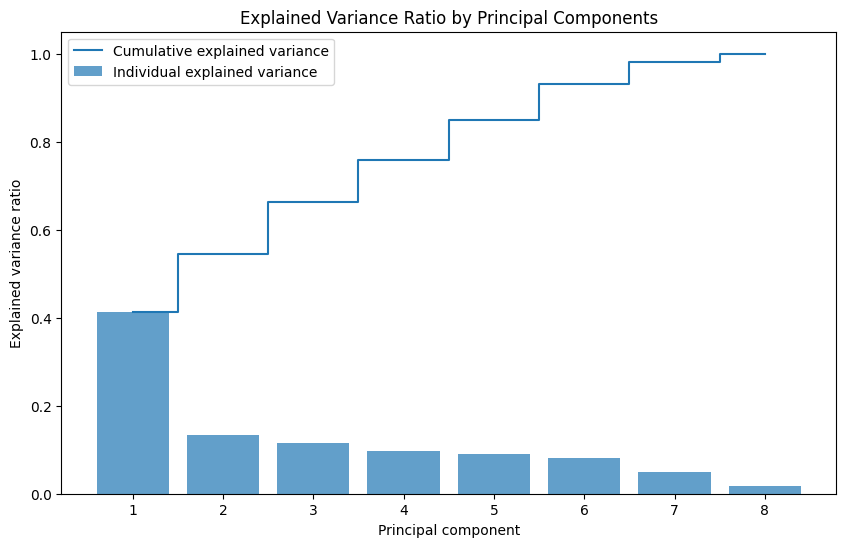

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Selecting the metrics for PCA
metrics_for_pca = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
data_for_pca = data[metrics_for_pca]

#Standardizing the metrics
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X=data_for_pca)

#Performing PCA
pca = PCA(random_state=523)
pca.fit(X=data_standardized)

#Explained variance ratio by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

#Plotting the explained variance ratio to see the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), where='mid', label='Cumulative explained variance')
#Add axis labels, legends, title
plt.ylabel(ylabel='Explained variance ratio')
plt.xlabel(xlabel='Principal component')
plt.legend(loc='best')
plt.title(label='Explained Variance Ratio by Principal Components')
#Show the plot
plt.show()

In [4]:
#Print the explained variance per component and the explained variance as a cumulative sum
explained_variance_ratio.round(decimals=2), explained_variance_ratio.cumsum().round(decimals=2)

(array([0.41, 0.13, 0.12, 0.1 , 0.09, 0.08, 0.05, 0.02]),
 array([0.41, 0.55, 0.66, 0.76, 0.85, 0.93, 0.98, 1.  ]))

The Principal Component Analysis (PCA) on the social media metrics resulted in the following insights:

The first principal component explains 41% of the variance within the data. This indicates that it captures a significant portion of the variability in engagement metrics. The second and third principal components explain an additional 13% and 12% of the variance, respectively. This shows a decrease in the amount of variance each subsequent component accounts for. 

Cumulatively, the first three components explain 66% of the variance. The cumulative explained variance reaches 76% with the inclusion of the fourth component, 85% with the fifth, and so on, until it accounts for 100% of the variance with all eight components. Based on the cumulative explained variance, a considerable amount of information is captured within the first few components. However, the decision on the number of components to retain would ideally balance between capturing a high proportion of variance and reducing dimensionality to a manageable level for interpretation and further analysis.

### 3. a) Scree Plot and Determination of Principal Components to Retain

Now I will develop a scree plot to visually assess how much variance each principal component explains.

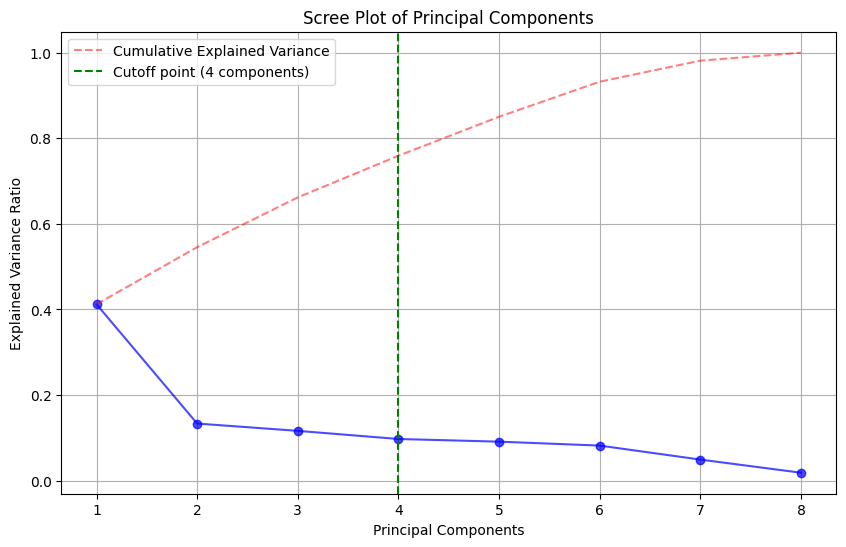

In [5]:
# Scree plot with a vertical line for the cutoff point
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', alpha=0.7, color='b')
plt.plot(range(1, len(explained_variance_ratio.cumsum()) + 1), explained_variance_ratio.cumsum(), marker='', linestyle='--', alpha=0.5, color='red', label='Cumulative Explained Variance')
plt.axvline(x=4, color='green', linestyle='--', label='Cutoff point (4 components)')

plt.ylabel(ylabel='Explained Variance Ratio')
plt.xlabel(xlabel='Principal Components')
plt.title(label='Scree Plot of Principal Components')
plt.legend(loc='best')
plt.grid(visible=True)
plt.show()

In the scree plot, I've drawn a vertical green line at the fourth principal component as the cutoff point. This decision is based on the following observations:

- The first four components explain 76% of the variance in the dataset, indicating a substantial capture of the information content.
- There's a noticeable "elbow" in the plot after the second component, where the slope of the curve becomes flatter, suggesting diminishing returns in explained variance for additional components.
- Retaining four components strikes a balance between simplifying the dataset and retaining a significant amount of variance, making the data more manageable for further analysis without losing crucial information.

### 3. b) Factor Loadings for the Retained Principal Components

In [6]:
#Instantiate a new model using the first four principal components
pca_4 = PCA(n_components=4, random_state=523)
pca_4.fit(data_standardized)

#Getting the factor loadings for the first four principal components
factor_loadings = pd.DataFrame(data=pca_4.components_.T, index=metrics_for_pca, columns=['PC1', 'PC2', 'PC3', 'PC4']).round(decimals=2)

factor_loadings

,PC1,PC2,PC3,PC4
num_comments,0.38,0.33,-0.04,-0.01
num_shares,0.48,0.03,-0.15,0.11
num_likes,0.16,-0.57,0.67,-0.37
num_loves,0.50,-0.07,-0.13,0.10
num_wows,0.30,-0.49,0.00,0.65
num_hahas,0.35,0.06,-0.16,-0.34
num_sads,0.16,0.57,0.70,0.28
num_angrys,0.34,0.05,-0.04,-0.47


Above are the factor loadings of the first four principal components, rounded to two decimal places.

- **PC1:** Has a strong positive loading on `num_shares` (0.48) and `num_loves` (0.50), as well as moderate positive loading on `num_comments` (0.38), `num_wows` (0.30) and `num_hahas` (0.35). It has no negative loadings whatsoever, with its two weakest loadings being `num_likes` and `num_sads` (0.16 for both).

- **PC2:** Has a strong positive loading on `num_sads` (0.57) and a moderate negative loading on both `num_likes` (-0.57) and `num_wows` (-0.49). It also has a moderate positive loading on `num_comments`(0.33). The other loadings are all less that 0.08 in magnitude, meaning they are not significant.

- **PC3:** Is characterized by strong positive loadings on `num_likes` (0.67) and `num_sads` (0.70), indicating a pattern that differentiates likes and sad reactions from other metrics.

- **PC4:** Has a strong positive loading on `num_wows` (0.65), and moderate negative loadings on `num_likes` (-0.37),  `num_angrys` (-0.47), and `num_hahas`.

### 3. c) Interpretation of the Retained Principal Components

**PC1:** This component combines elements such as shares, loves, comments, wows, and hahas. Because most of the engagement options have strong positive loadings, we can conclude that users engage with this type of content with a range of different emotions. This component might represent content that is widely appealing to many demographics and therefore prompts a variety of reactions from the audience. This component has no negative loadings, but it does have weaker loadings for likes and sads compared to the other engagements. The weaker loading for likes may mean that these posts are typically photos and videos, not text.

**PC2:** With strong positive loadings on sads and negative on likes and wows, this component may represent content that generates unhappy reactions. The moderately positive loading on comments may also suggest that users are driven to comment out of negative emotion, a behavior that has been observed many times and is common knowledge in the social media community. Because it does not have a strong positive loading for angrys, this content is likely driving sad reactions either through sympathy and/or empathy as opposed to posting content that the user emotionally disagrees with. This means this is not necessarily content that the audience dislikes, it is just content that caused a sad emotion. It is also important to remember that users can only choose one reaction type, so content that has a lot of sad reactions will not have as many likes (or hahas, wows, etc.), at least partially explaining the negative loading for this component and likes/wows.

**PC3:** The strong positive loadings with likes and sads indicates content that particularly resonates emotionally with the audience. This is similar to the previous component, with the key difference being that likes has a strong positive loading instead of a strong negative loading. Again, this is likely content that drives engagement through sympathy or empathy. A potential difference is that this content could include a resolution to the conlfict it presents. For example, consider the difference between a video that shows an abandoned puppy vs. a video that shows an abandoned puppy being taken in, treated, and adopted. Both videos would gather sad reactions, but the second video may also gather likes as well, since it shows a satisfactory ending. The negative loading here are all fairly weak, although it is notable that this is the only component of these four with a negative loading for shares. Perhaps people are less inclined to share content that makes them sad.

**PC4:** Dominated by wows, with moderate negative loadings with likes, angrys, and hahas, this component could represent content that simply surprises or astonishes the audience. The pure shock would lead to a high number of wow reactions but fewer reaction of other emotions. A slight positive correlation with sads may indicate that this is in fact shock content - content that is designed to cause a strong reaction from the viewer. This loading is only 0.28, however, so the majority of content that falls under this principal component is probably not designed to upset the viewer. The negative loadings with likes, hahas, and angrys are all moderate, which suggests that users do not find the content pleasing, funny, or aggravating; rather, they are just surprised or impressed by what they have seen/read.

### 3. d) Renaming Principal Components Based on Interpretation

Based on the factor loadings and my interpretation of them, I have chosen the following names:

- **PC1:** Broad Engagement
- **PC2:** Unhappy Emotions
- **PC3:** Sad-Happy Content
- **PC3:** Surprise Factor

### 4. Segmentation with K-Means Clustering

In [7]:
from sklearn.cluster import KMeans

#Calculate PCA for each row for K-Means grouping as shown in Script 06
row_loadings = pd.DataFrame(data=pca_4.transform(data_standardized), columns=['PC1', 'PC2', 'PC3', 'PC4'])

#Finding the optimal number of clusters using the elbow method
wcss_reduced = []
#Reducing the range for quicker computation
for i in range(1, 10):  
    kmeans_reduced = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_reduced.fit(row_loadings)
    wcss_reduced.append(kmeans_reduced.inertia_)

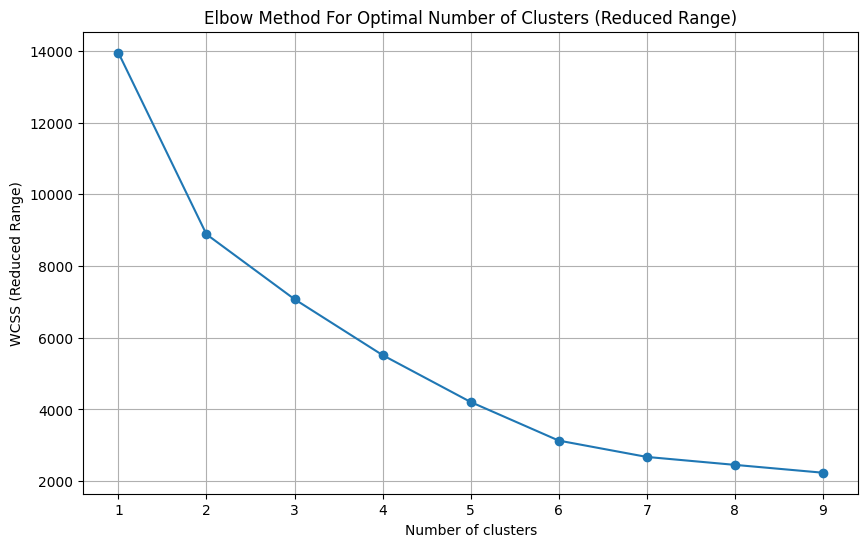

In [8]:
#Plotting the results of the elbow method with the reduced range
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss_reduced, marker='o', linestyle='-')
#Add title, axis labels, and grid
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Reduced Range)')
plt.grid(True)
#Show the plot
plt.show()

### 4. a) Ideal Number of Clusters and Rationale

The plot above displays the Within-Cluster-Sum-of-Squares (WCSS) for 1 to 9 clusters, utilizing the elbow method to determine the optimal number of clusters. The plot shows a notable decrease in WCSS from 1 to 2 clusters and continues to decline as the number of clusters increases, but the rate of decline diminishes. The "elbow" point, where the decrease in WCSS begins to slow, is not as pronounced in this reduced range, suggesting a relatively smooth decrease in WCSS. Given the plot and considering the goal of achieving meaningful segmentation without overcomplicating the model, choosing 3 clusters should be a reasonable compromise.

I will perform K-Means clustering with 3 clusters.

The decision to use 3 clusters for the segmentation is based on the analysis detailed above. This analysis used the elbow method, which helps identify the optimal balance between minimizing within-cluster variance (WCSS) and keeping the model complexity manageable. The choice reflects a balance between detail and clarity. With 3 clusters, the segmentation provides a nuanced view of the data without becoming overly fragmented, making it easier to derive actionable insights. Using 3 clusters alsoallows for the identification of clear strategies that can be tailored to each segment, making actual application of this information more practical for our firm.

In [9]:
#Getting the factor loadings on a per-row level for K-means grouping as shown in Script 06
row_loadings = pd.DataFrame(data=pca_4.transform(data_standardized), columns=['PC1', 'PC2', 'PC3', 'PC4'])

pca_rescaled = scaler.fit_transform(X=row_loadings)

#Performing k-means clustering with the optimal number of clusters (3)
kmeans_final = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init='auto', random_state=523)
kmeans_final.fit(pca_rescaled)

#Converting the clusters to a DataFrame
kmeans_pca = pd.DataFrame({'Cluster': kmeans_final.labels_})

### 4. b) Segment Interpretation and Examples

In [10]:
#Storing cluster centers
centroids_pca = kmeans_final.cluster_centers_

#Converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(centroids_pca).round(decimals = 2)

#Renaming principal components
centroids_pca_df.columns = ['Broad Engagement',
                            'Unhappy Emotions',
                            'Sad-Happy Content',
                            'Surprise Factor']

#Checking results (clusters = rows, pc = columns)
centroids_pca_df

,Broad Engagement,Unhappy Emotions,Sad-Happy Content,Surprise Factor
0,-0.22,-0.06,-0.00,0.02
1,2.96,0.54,-0.43,-0.44
2,1.90,8.92,11.58,4.46


The K-Means clustering has segmented the data into 3 segments based on the PCA scores of the first four principal components. The centroids of each cluster have been printed and have the following characteristics:

- **Cluster 0:** This segment has small principal component scores across the board, which indicates content that does not achieve any significant level of engagement. This probably represents the vast majority of posts which are made by non-famous accounts. Most of these posts do not gain any traction and therefore have a low level of engagement. This is reinforced by the fact that the only correlation which is even somewhat significant is -0.22 with the "Broad Engagement" component. Again, this would suggest that the content in this segment does not receive much engagement at all, since "Broad Engagement" encompasses a positive loading with each engagement type.

- **Cluster 1:** This segment is characterized by a high positive score for "Broad Engagement" and a moderate positive score for "Unhappy Emotions". This cluster includes content that drives a high level of engagement across all engagement types and somewhat often elicits a sad response. These could be posts that appeal to a broad audience and sometimes feature sob stories to stir up sympathy and drive users to share and comment. The negative association with the last two components indicates that this segment does not gather as many likes or wows. Still, these associations are weak in comparison to the positive association with "Broad Engagement", so they are most likely not that significant in practice.

- **Cluster 2:** This segment is positive across the board, with particularly high high scores for "Sad-Happy Content" and "Unhappy Emotions", both of which have positive loadings for sad reactions. Posts in this cluster are most likely high-performers that gain a large amount of engagement. They likely accomplish this by successfully eliciting emotional reactions - those that might be touching or heartfelt, leading to a complex mix of sad and happy reactions. The fact that all the principle components have a positive association with this segment means that the posts in this segment receive a varied mix of reaction types and amounts. For example, some components have positive loading for comments while others have negative, meaning that posts in this segment sometimes receive many comments and sometimes do not.

**Example: Cluster 0**
- A suburban father posting a picture of his freshly-mowed lawn.

**Example: Cluster 1**
- A local news network posting a video about a family who lost their house in a natural disaster but recovered thanks to the help of the community.

**Example: Cluster 2**
- A puppy shelter posting a video of sad puppies with text stating that the puppies will have to be put down if no one comes to adopt them and emphasizing the importance of choosing adoption over purchasing a puppy.

### 4. c) Segment Renaming

Based on the interpretation above, I propose the following names for the segments:

- **Cluster 0:** "Background Chatter" - The general fluff that the masses post on a daily basis.
- **Cluster 1:** "Algorithm Pleasers" - Content that appeals to everyone (young, old, male, female, etc.) that plays into "the algorithm" of Facebook very well.
- **Cluster 2:** "Emotional Resonators" - Content that deeply connects with the audience on an emotional level, possibly through imagery, storytelling, or impactful messages.

### 4. d) Analysis of Status Types by Segment

To analyze the status types of each segment and their relation to videos, we'll calculate the distribution of status types (e.g., video, photo, text) within each cluster. This will help us understand how different content types contribute to the engagement patterns observed in each segment, with a particular focus on videos. Let's perform this analysis.

In [16]:
#Concatenating cluster memberships with principal components
clst_pca_df = pd.concat([kmeans_pca, row_loadings], axis=1)

#Concatenating status type with pca-clusters
final_df = pd.concat([data.loc[ : , ['status_type']], clst_pca_df.round(decimals=2)], axis=1)

#Dynamic string with distribution for each post type for each cluster segment
print(f"""\
----------------------
| Background Chatter |
----------------------

Proportion of Observations
--------------------------
{round(len(final_df.loc[:, "Cluster"][final_df.loc[:, "Cluster"]==0]) / len(final_df), ndigits=2)}

Status Type
-------
{final_df.loc[:, "status_type"][ final_df.loc[:, 'Cluster']==0].value_counts(normalize=True).round(decimals=2).sort_index().to_string(dtype=False, name=False)}
""")

print(f"""\
---------------------
| Algorithm Pleaser |
---------------------

Proportion of Observations
--------------------------
{round(len(final_df.loc[:, "Cluster"][final_df.loc[:, "Cluster"]==1]) / len(final_df), ndigits=2)}

Status Type
-------
{final_df.loc[:, "status_type"][ final_df.loc[:, 'Cluster']==1].value_counts(normalize=True).round(decimals=2).sort_index().to_string(dtype=False, name=False)}
""")

print(f"""\
-----------------------
| Emotional Resonator |
-----------------------

Proportion of Observations
--------------------------
{round(len(final_df.loc[:, "Cluster"][final_df.loc[:, "Cluster"]==2]) / len(final_df), ndigits=2)}

Status Type
-------
{final_df.loc[:, "status_type"][final_df.loc[:, 'Cluster' ]==2].value_counts(normalize=True).round(decimals=2).sort_index().to_string(dtype=False, name=False)}
""")

----------------------
| Background Chatter |
----------------------

Proportion of Observations
--------------------------
0.93

Status Type
-------
status_type
photo    0.64
text     0.06
video    0.30

---------------------
| Algorithm Pleaser |
---------------------

Proportion of Observations
--------------------------
0.07

Status Type
-------
status_type
photo    0.05
text     0.01
video    0.95

-----------------------
| Emotional Resonator |
-----------------------

Proportion of Observations
--------------------------
0.0

Status Type
-------
status_type
photo    0.67
video    0.33



In [12]:
#Analyzing the counts of status types within each cluster
status_type_distribution = pd.DataFrame(final_df.groupby(['Cluster', 'status_type']).size().unstack(fill_value=0))
status_type_distribution.columns.name = 'Segment Name'
status_type_distribution.index = ['Background Chatter', 'Algorithm Pleaser', 'Emotional Resonator']
status_type_distribution

Segment Name,photo,text,video
Background Chatter,1374,133,632
Algorithm Pleaser,7,1,144
Emotional Resonator,4,0,2



The distribution of status types within each segment reveals distinct patterns:

**Background Chatter**

Makes up 93% of the statuses posted, an overwhelming majority. Dominated by photos (1374 posts, ~64%), with videos coming in a distant second (632 posts, ~30%), and text posts as a very small minority (133, ~6%). This means that most people are posting a photo or video when they post a status. It is actually somewhat surprising how few people are posting text-only Facebook statuses, given that this was the primary type of status posted a little over a decade ago. Regardless, this means that video posts make up a significant number of the total statuses on Facebook, meaning that there is much competition among this type of media.

**Algorithm Pleaser**

This segment only comprises 7% of statuses, but is what I believe to be the most successful segment in terms of total engagement. Videos make up the vast majority of posts in this segment (144 posts, ~95%), with a very small number of photos (7, ~5%) and text posts (1, ~1%) filling in the rest. The prominence of videos in this cluster underscores their effectiveness in sparking conversations and shares, indicating that video content is particularly potent in driving active engagement. Despite photo statuses being more common as a whole, we see that among successful statuses, photos only make up 5%. This further reinforces the notion that video content is by far the most powerful for generating engagement.

**Emotional Resonators**

This segment contains very few posts, with only 6 posts total, putting it at less than 1% of the data. It consists only of photos (4 posts, ~66.6%) and videos (2 posts ~33.3%), indicating that text statuses are not good at eliciting emotional responses. Videos seem to be better at this than photos as well, since their count is doubled.

### Findings Related to Videos

Videos are a significant presence in all clusters, especially dominant in the "Algorithm Pleasers" segment. This supports the notion that videos are particularly effective in engaging audiences, capable of not only generating general engagement but also sparking conversations and eliciting strong, emotional reactions.


### 5. Logistic Regression Models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Prepare the target variable
final_df['is_video'] = (final_df['status_type'] == 'video').astype(int)

#Model 1: Using original x-features
X1 = data[metrics_for_pca]
y = final_df['is_video']
X_train_1, X_test_1, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=523)

#Model 2: Using retained principal components
X2 = row_loadings
X_train_2, X_test_2, y_train_2 , y_test_2 = train_test_split(X2, y, test_size=0.3, random_state=523)

# Model 3: Using retained clusters
#Factorizing cluster results
X3 = pd.get_dummies(data=kmeans_pca['Cluster'], drop_first=True).astype(dtype=int)
X_train_3, X_test_3, y_train_3 , y_test_3 = train_test_split(X3, y, test_size=0.3, random_state=523)

# Initializing and fitting the logistic regression models
orig_reg = LogisticRegression(max_iter=500, random_state=523).fit(X_train_1, y_train)
pca_reg = LogisticRegression(max_iter=500, random_state=523).fit(X_train_2, y_train_2)
cluster_reg = LogisticRegression(max_iter=500, random_state=523).fit(X_train_3, y_train_3)

# Predictions and evaluations
predictions_1 = orig_reg.predict(X=X_test_1)
predictions_2 = pca_reg.predict(X=X_test_2)
predictions_3 = cluster_reg.predict(X=X_test_3)

#Calculate accuracy metric for the three models
accuracy_1 = accuracy_score(y_true=y_test, y_pred=predictions_1)
accuracy_2 = accuracy_score(y_true=y_test_2, y_pred=predictions_2)
accuracy_3 = accuracy_score(y_true=y_test_3, y_pred=predictions_3)

#Calculate AUC metric for the three models
auc_1 = roc_auc_score(y_true=y_test, y_score=predictions_1)
auc_2 = roc_auc_score(y_true=y_test_2, y_score=predictions_2)
auc_3 = roc_auc_score(y_true=y_test_3, y_score=predictions_3)

#Create model performance results dataframe
model_performance = pd.DataFrame({
    'Model': ['Original X-Features', 'Retained Principal Components', 'Retained Clusters'],
    'Accuracy': [accuracy_1, accuracy_2, accuracy_3],
    'AUC Score': [auc_1, auc_2, auc_3]
})

#Display the dataframe with results rounded to 2 decimal places
model_performance.round(decimals=2)

,Model,Accuracy,AUC Score
0,Original X-Features,0.81,0.73
1,Retained Principal Components,0.79,0.71
2,Retained Clusters,0.72,0.59


The performance of the three logistic regression models based on different features is summarized as follows:

- **Model 1 (Original X-Features):** Achieved an accuracy of 0.81 and an AUC score of 0.73. This model used the original engagement metrics as features.
- **Model 2 (Retained Principal Components):** Reached an accuracy of 0.79 and an AUC score of 0.71. The model utilized the scores from the first four principal components.
- **Model 3 (Retained Clusters):** Had an accuracy of 0.72 and an AUC score of 0.59, with the cluster assignments as a feature.

### 6. Final Model Selection

### 6. a) Rationale

Based on the evaluation metrics, Model 1, which uses the original engagement metrics as features, is selected as the best model. The rationale for this choice includes:

- **Higher Accuracy and AUC Score:** Model 1 outperforms the other models in terms of both accuracy and AUC score, indicating a better overall performance in classifying posts as video or not video. While accuracy only looks at correct predictions, AUC is a more balanced metric, and this model performs the best when measured on both these metrics. The model's superior performance across both metrics suggests it performs better than the others regardless of which type of error should be minimized. 
- **Comprehensive Feature Set:** By leveraging the original metrics, Model 1 captures a wide range of engagement signals that are directly relevant to the content type, providing a nuanced understanding of what drives video content. Using the original metrics is better in this case as it allows for more detailed insights into the data. PCA would be appropriate if we had even more metrics to deal with, but the number that we have now is still manageable without any dimensionality-reduction techniques.
- **Practical Applicability:** The model's reliance on readily available engagement metrics makes it a practical tool for real-world applications. Since these metrics can be pulled directly from Facebook, content creators and marketers can assess the potential impact of their strategies on content engagement without needing the technical knowledge to transform the data first.

### 6. b) Results

In [14]:
#Generate predictions on training data to calculate train-test gap for accuracy and AUC
train_predictions_1 = orig_reg.predict(X=X_train_1)
#Calculate accuracy and AUC for training predictions to calculate train-test gap
train_accuracy_1 = accuracy_score(y_true=y_train, y_pred=train_predictions_1)
train_auc_1 = roc_auc_score(y_true=y_train, y_score=train_predictions_1)
#Calculate the train-test gaps
train_test_gap_accuracy_1 = abs(train_accuracy_1 - accuracy_1)
train_test_gap_auc_1 = abs(train_auc_1 - auc_1)
#Put all metrics into a dataframe
model_performance = pd.DataFrame({
    'Train Accuracy': [train_accuracy_1],
    'Test Accuracy': [accuracy_1],
    'Train-Test Gap (Accuracy)': [train_test_gap_accuracy_1],
    'Train AUC Score': [train_auc_1],
    'Train AUC Score': [auc_1],
    'Train-Test Gap (AUC)': [train_test_gap_auc_1]
}).T
#Rename column containing values
model_performance.columns = ['Value']
#Display the dataframe
model_performance.round(decimals=2)

,Value
Train Accuracy,0.80
Test Accuracy,0.81
Train-Test Gap (Accuracy),0.01
Train AUC Score,0.73
Train-Test Gap (AUC),0.02


**Accuracy Train-Test Gap:** 0.01

Because this is a very small drop in performance, it indicates that the model generalizes well and would likely perform well on unseen, real-world data.

**AUC Train-Test Gap:** 0.02

Having such a small train-test gap for AUC, which is a more robust metric than accuracy, is further evidence that this model is not overfit and in fact generalizes quite well to unseen data.

### 6. c) Confusion Matrix

In [15]:
#Generating the confusion matrix for Model 1
conf_matrix = confusion_matrix(y_test, predictions_1)

#Put the confusion matrix into a dataframe and display it
pd.DataFrame(conf_matrix, columns=['Predicted Not Video', 'Predicted Video'], index=['Actual Not Video', 'Actual Video'])

,Predicted Not Video,Predicted Video
Actual Not Video,448,8
Actual Video,120,114


### Error Analysis and Risks

**False Positives (Type I Error):**

The model incorrectly predicted 8 non-video posts as videos. While the number is relatively low, this type of error could lead to misallocated resources or strategies if marketers over-prioritize video content based on these predictions.

**False Negatives (Type II Error):** 

More significantly, 120 video posts were incorrectly classified as non-video. This error is more concerning as it suggests missed opportunities to recognize and leverage highly engaging video content, potentially misrepresenting the impact of video in a content strategy.

The relatively high number of false negatives compared to false positives indicates a tendency of the model to be conservative in predicting video content. This could lead to a bias towards non-video content in strategic decision-making. These errors highlight the importance of complementing predictive modeling with content analysis and audience insight to accurately identify and promote engaging video content.

While the model performs well overall, reducing the number of false negatives could significantly enhance its utility. This could involve feature engineering, model tuning, or incorporating additional contextual information.